# Bayesian VAR Tutorial

This tutorial illustrates the estimation of a **Bayesian Vector Autoregression (BVAR(1))** using quarterly Peruvian macroeconomic data from **1997Q1 to 2019Q4**.

The model includes three key variables:

- **Export Price Index Growth** ($\text{xpi}_t$)
- **Real GDP Growth** ($\text{gdp}_t$)
- **Tax Revenue Growth** ($\text{tax}_t$)

This setup serves as a **small macro-fiscal model** for Peru, designed to capture the main drivers of tax revenue fluctuations. Based on stylized facts and institutional practice, tax revenues in Peru are primarily influenced by two channels:

- **International prices**, particularly for minerals, which affect **income tax revenues**
- **Domestic economic activity**, which drives **VAT collections**

While more complex models may include additional variables, these three are widely regarded as the core indicators used by official institutions for **fiscal forecasting** and **policy analysis**.

This tutorial demonstrates how a BVAR framework can be used to model these interactions, perform inference, and generate both unconditional and scenario-based forecasts for fiscal planning.

In [ ]:
import pandas as pd

df = pd.read_csv('../datasets/Peru_Data.csv', index_col=0, parse_dates=True) # Make sure the index is parsed as a datetime format
df.rename(columns={'g_ipx': 'xpi', 'g_pbi': 'gdp', 'g_icgg': 'tax'}, inplace=True)
df.head()

,xpi,gdp,tax
date,,,
1997-03-01,0.672680,5.179629,11.974175
1997-06-01,0.394339,8.230561,2.700469
1997-09-01,8.866004,6.404664,6.859245
1997-12-01,-1.280914,5.981782,6.494577
1998-03-01,-6.438255,2.227753,2.295141


## 1. Visualization of Macroeconomic Time Series

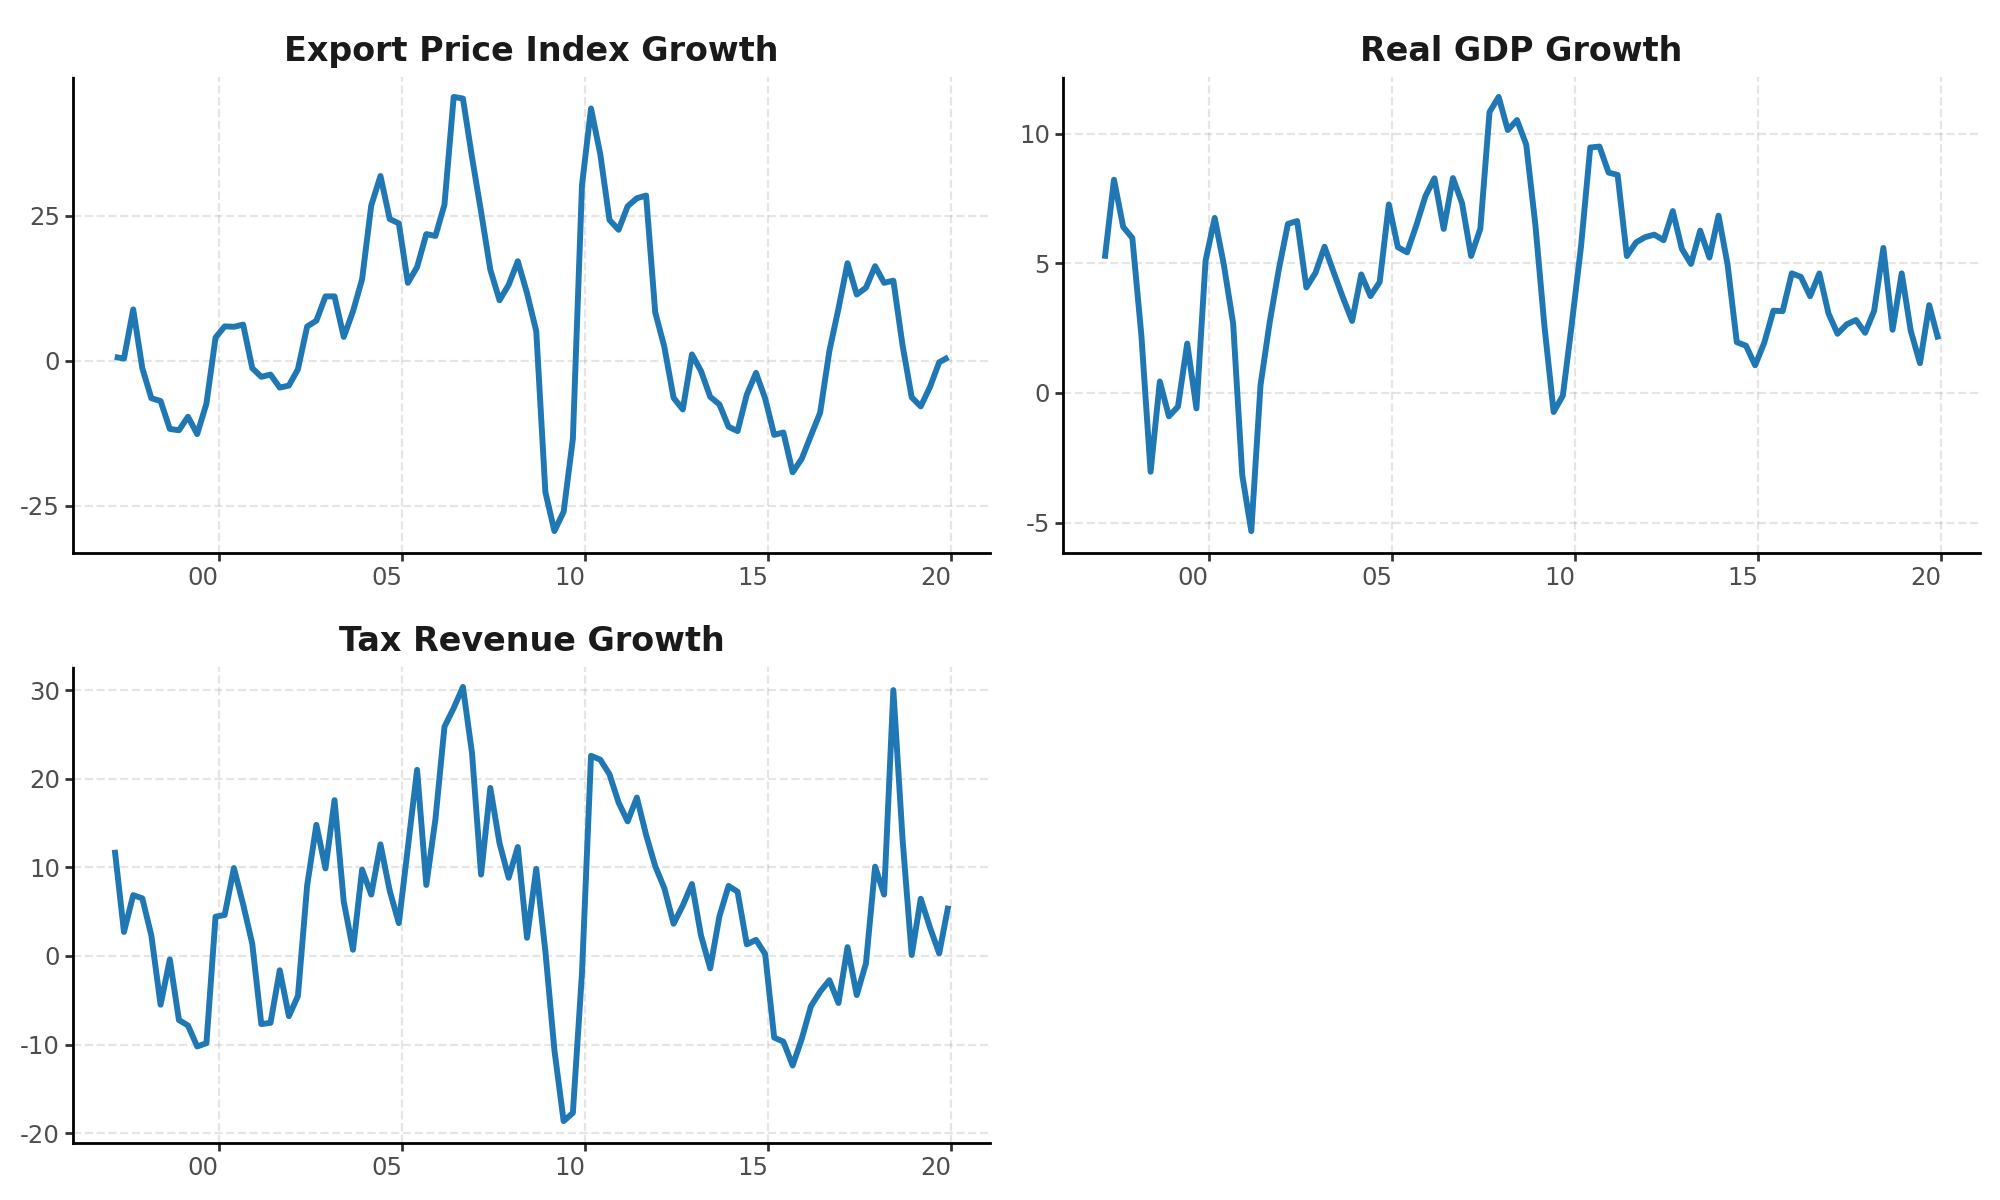

In [11]:
from MacroPy import generate_series_plot

series_titles = ["Export Price Index Growth", "Real GDP Growth", "Tax Revenue Growth"]
generate_series_plot(df, series_titles=series_titles)

## 2. Estimating a Bayesian VAR with `MacroPy`

We estimate a **Bayesian VAR model with 1 lag** using `MacroPy`, including $\text{xpi}_t$, $\text{gdp}_t$, and $\text{tax}_{t}$ as endogenous variables.

In [12]:
from MacroPy import BayesianVAR

bvar = BayesianVAR(df)
bvar.model_summary()


**MacroPy Toolbox for Macroeconometric Analysis in Python**  
Developed by [Renato Vassallo](https://www.linkedin.com/in/renatovassallo), Institute for Economic Analysis (IAE-CSIC)  
Version 0.1.3, May 2025  

---

**Model Specifications**  
- **Model Type**: Bayesian VAR  
- **Endogenous Variables**: xpi, gdp, tax  
- **Exogenous Variables**: Constant   
- **Number of Lags**: 1  
- **Total Number of Coefficients to Estimate**: 12  

---

**MCMC Algorithm**: Gibbs Sampling  
- **Prior Type**: Minnesota  
- **Iterations**: 5000  
- **Burn-in**: 2500 (50%)  

---

**Forecast & IRF Details**  
- **Impulse Response Horizon**: 20  
- **Forecast Horizon**: 12  
- **IRF Computation**: 1 Standard Deviation  

---

**VAR Model Equations**

$$
\begin{align*}
xpi_{t} &= b_{1,1}^{1} xpi_{t-1} + b_{1,2}^{1} gdp_{t-1} + b_{1,3}^{1} tax_{t-1} + c_{1} + e_{t}^{xpi} \\
gdp_{t} &= b_{2,1}^{1} xpi_{t-1} + b_{2,2}^{1} gdp_{t-1} + b_{2,3}^{1} tax_{t-1} + c_{2} + e_{t}^{gdp} \\
tax_{t} &= b_{3,1}^{1} xpi_{t-1} + b_{3,2}^{1} gdp_{t-1} + b_{3,3}^{1} tax_{t-1} + c_{3} + e_{t}^{tax} \\
\end{align*}
$$


## 3. Sampling from the Posterior Distribution

We now draw samples from the **posterior distribution** of the BVAR model parameters using Gibbs sampling.

The command below performs posterior simulation and, with `plot_coefficients=True`, visualizes the distribution of estimated coefficients:

Sampling Posterior: 100%|██████████| 5000/5000 [00:00<00:00, 15428.28it/s]


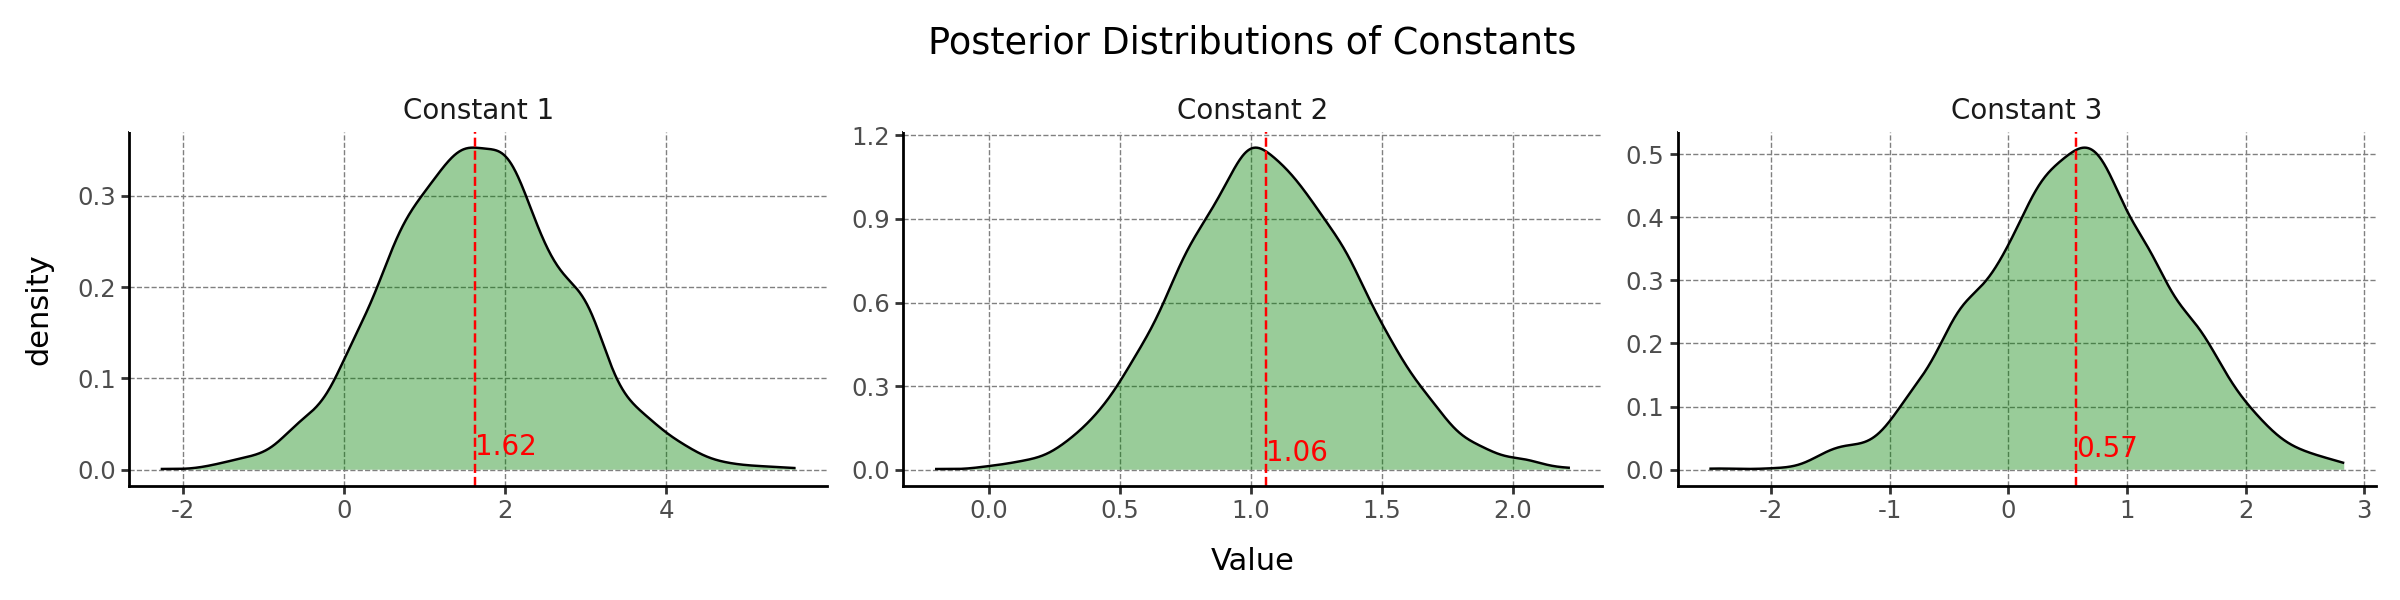

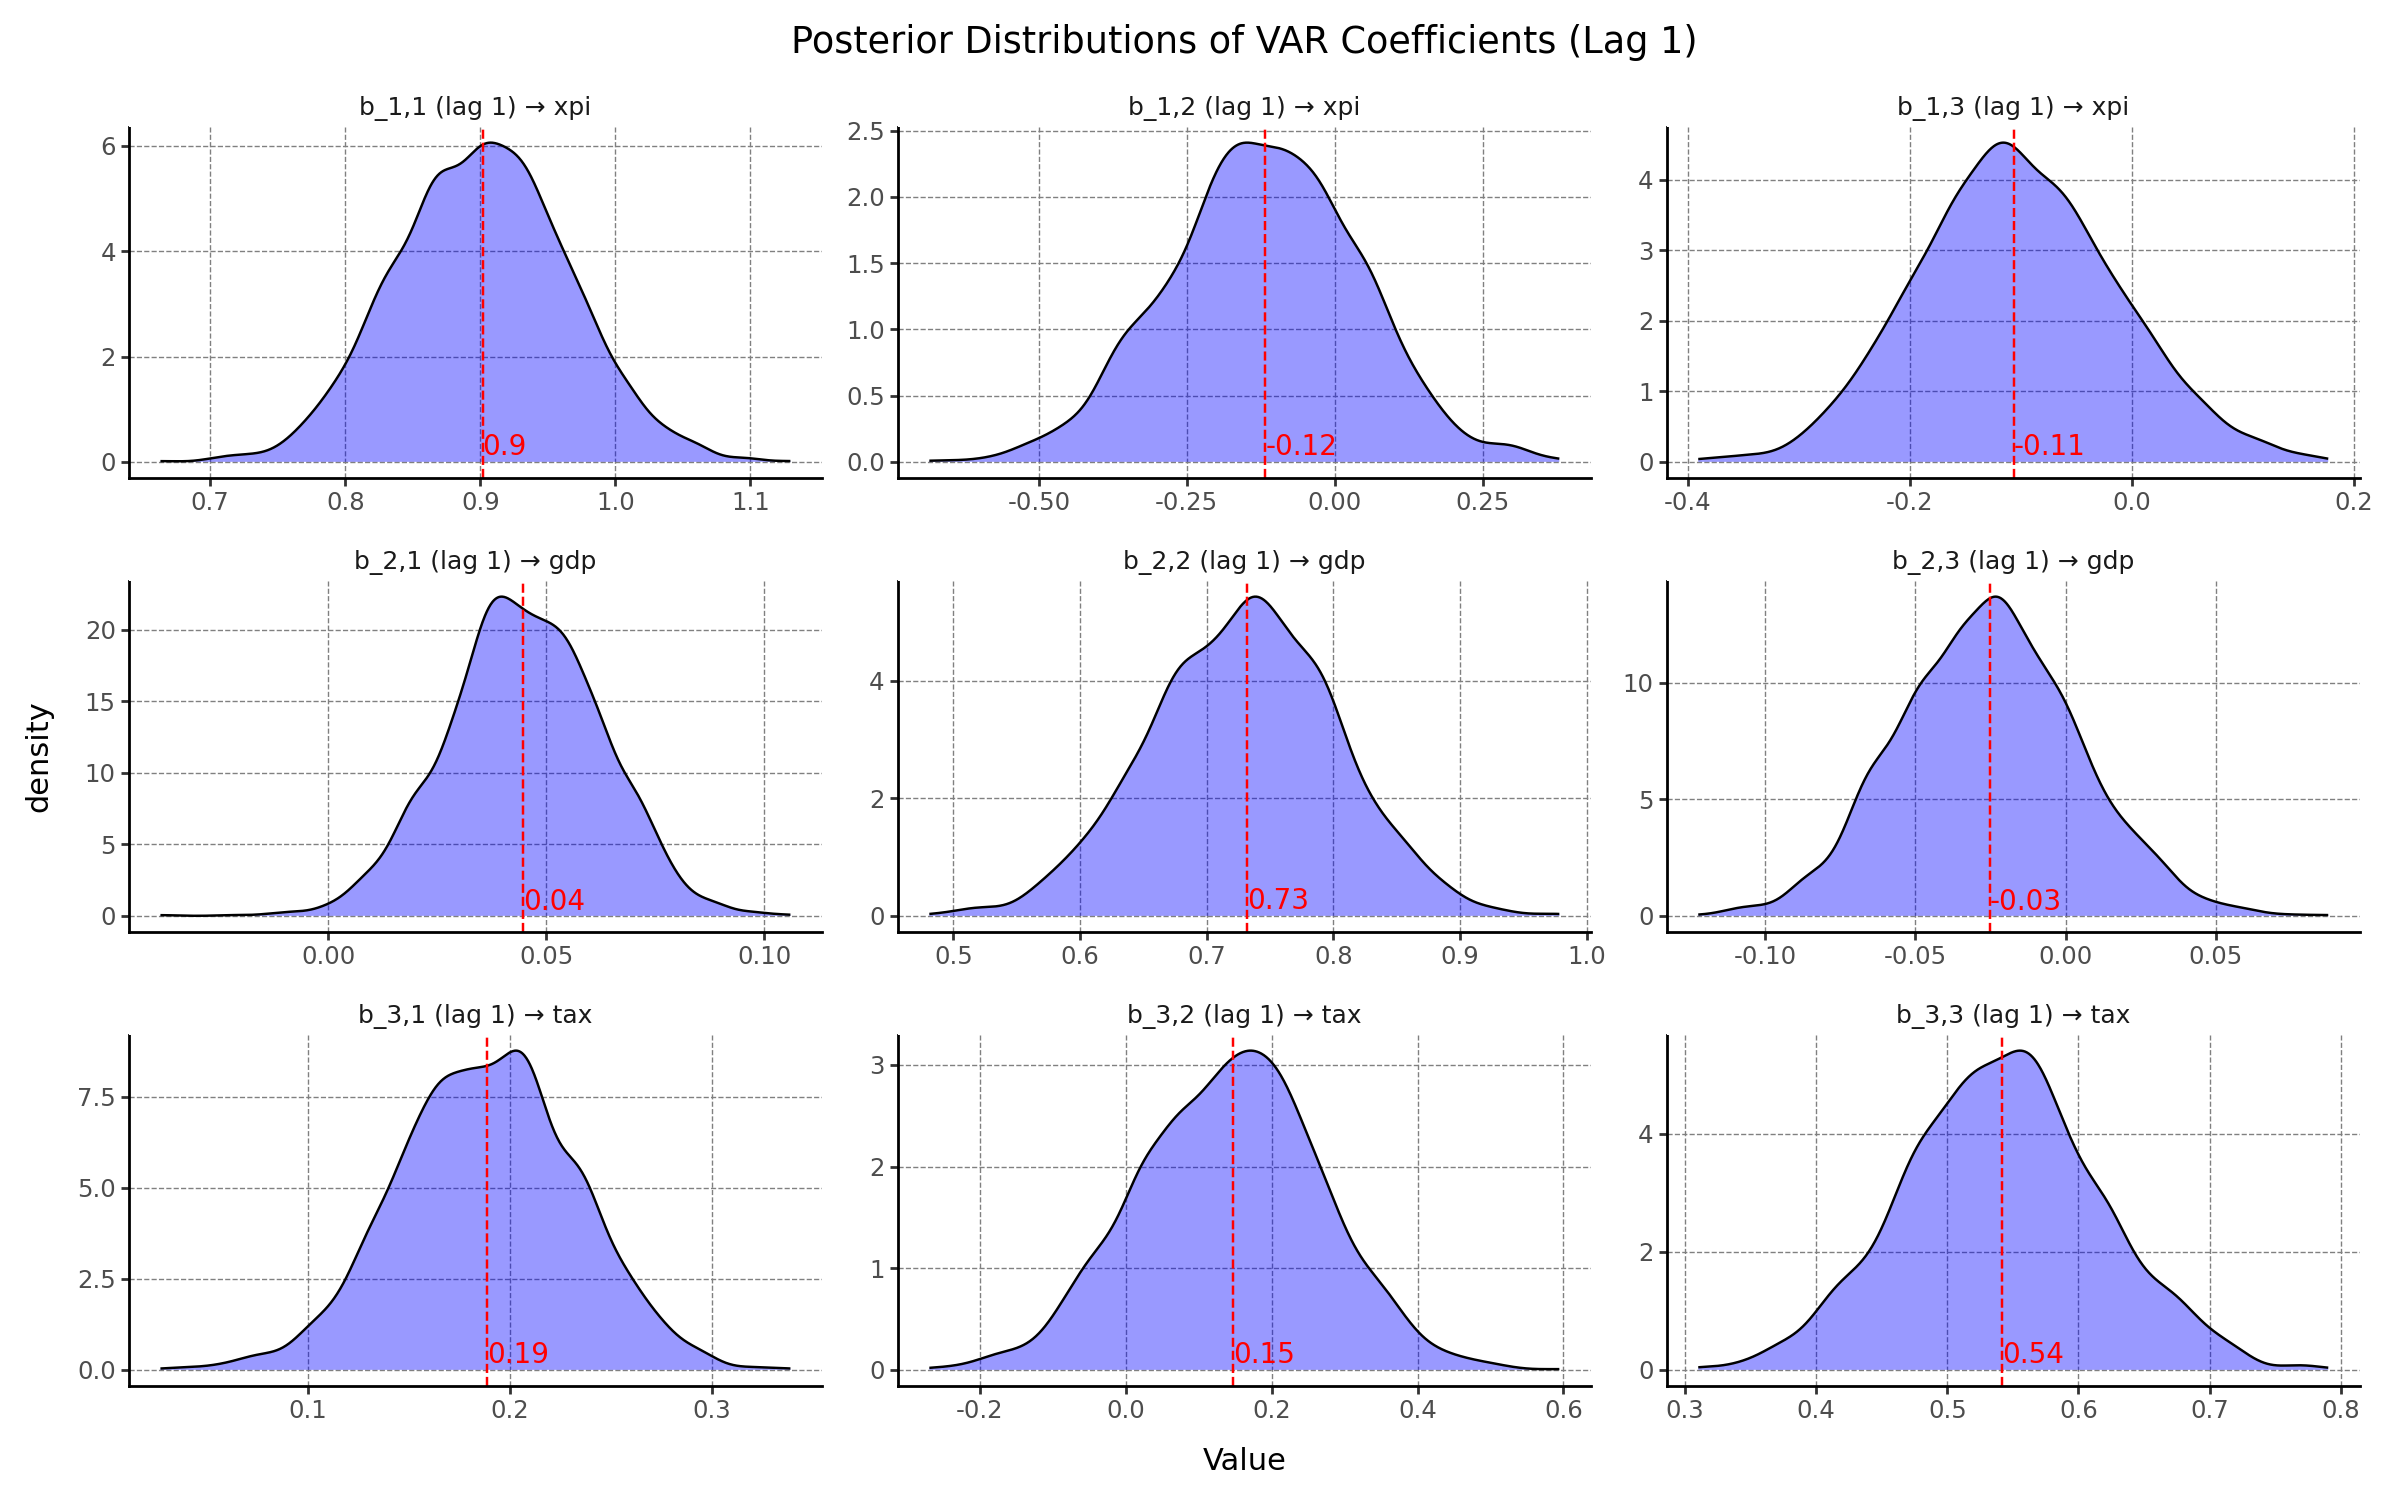

In [13]:
bvar.sample_posterior(plot_coefficients=True)

## 4. Computing Impulse Response Functions (IRFs)

Next, we compute **Impulse Response Functions (IRFs)** to analyze how each variable in the system responds to structural shocks over time.

The command below generates IRFs from the posterior draws of the BVAR model and plots the responses with **credible intervals** at 68% and 95% confidence levels.

Computing IRFs: 100%|██████████| 2500/2500 [00:00<00:00, 4383.01it/s]


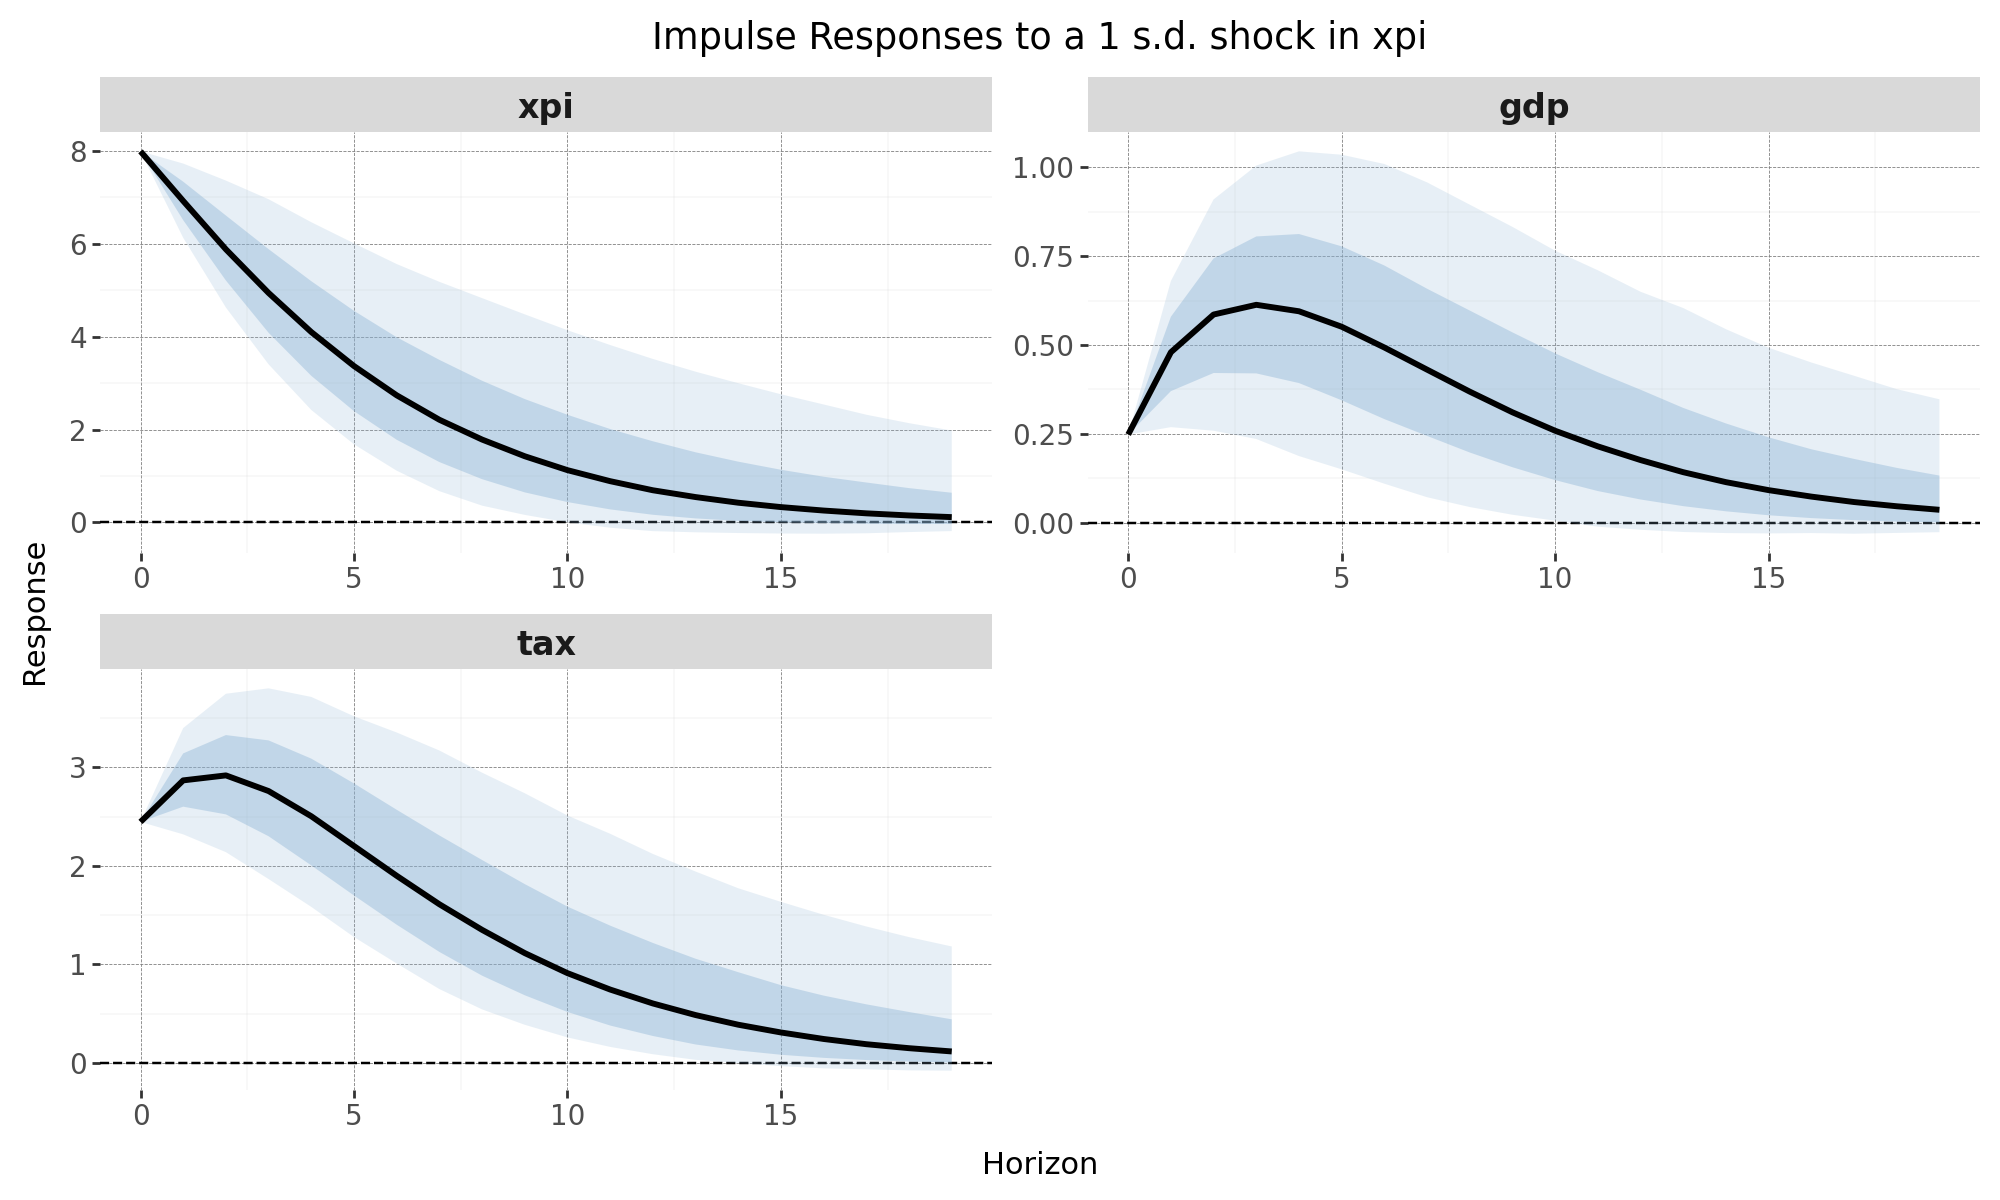

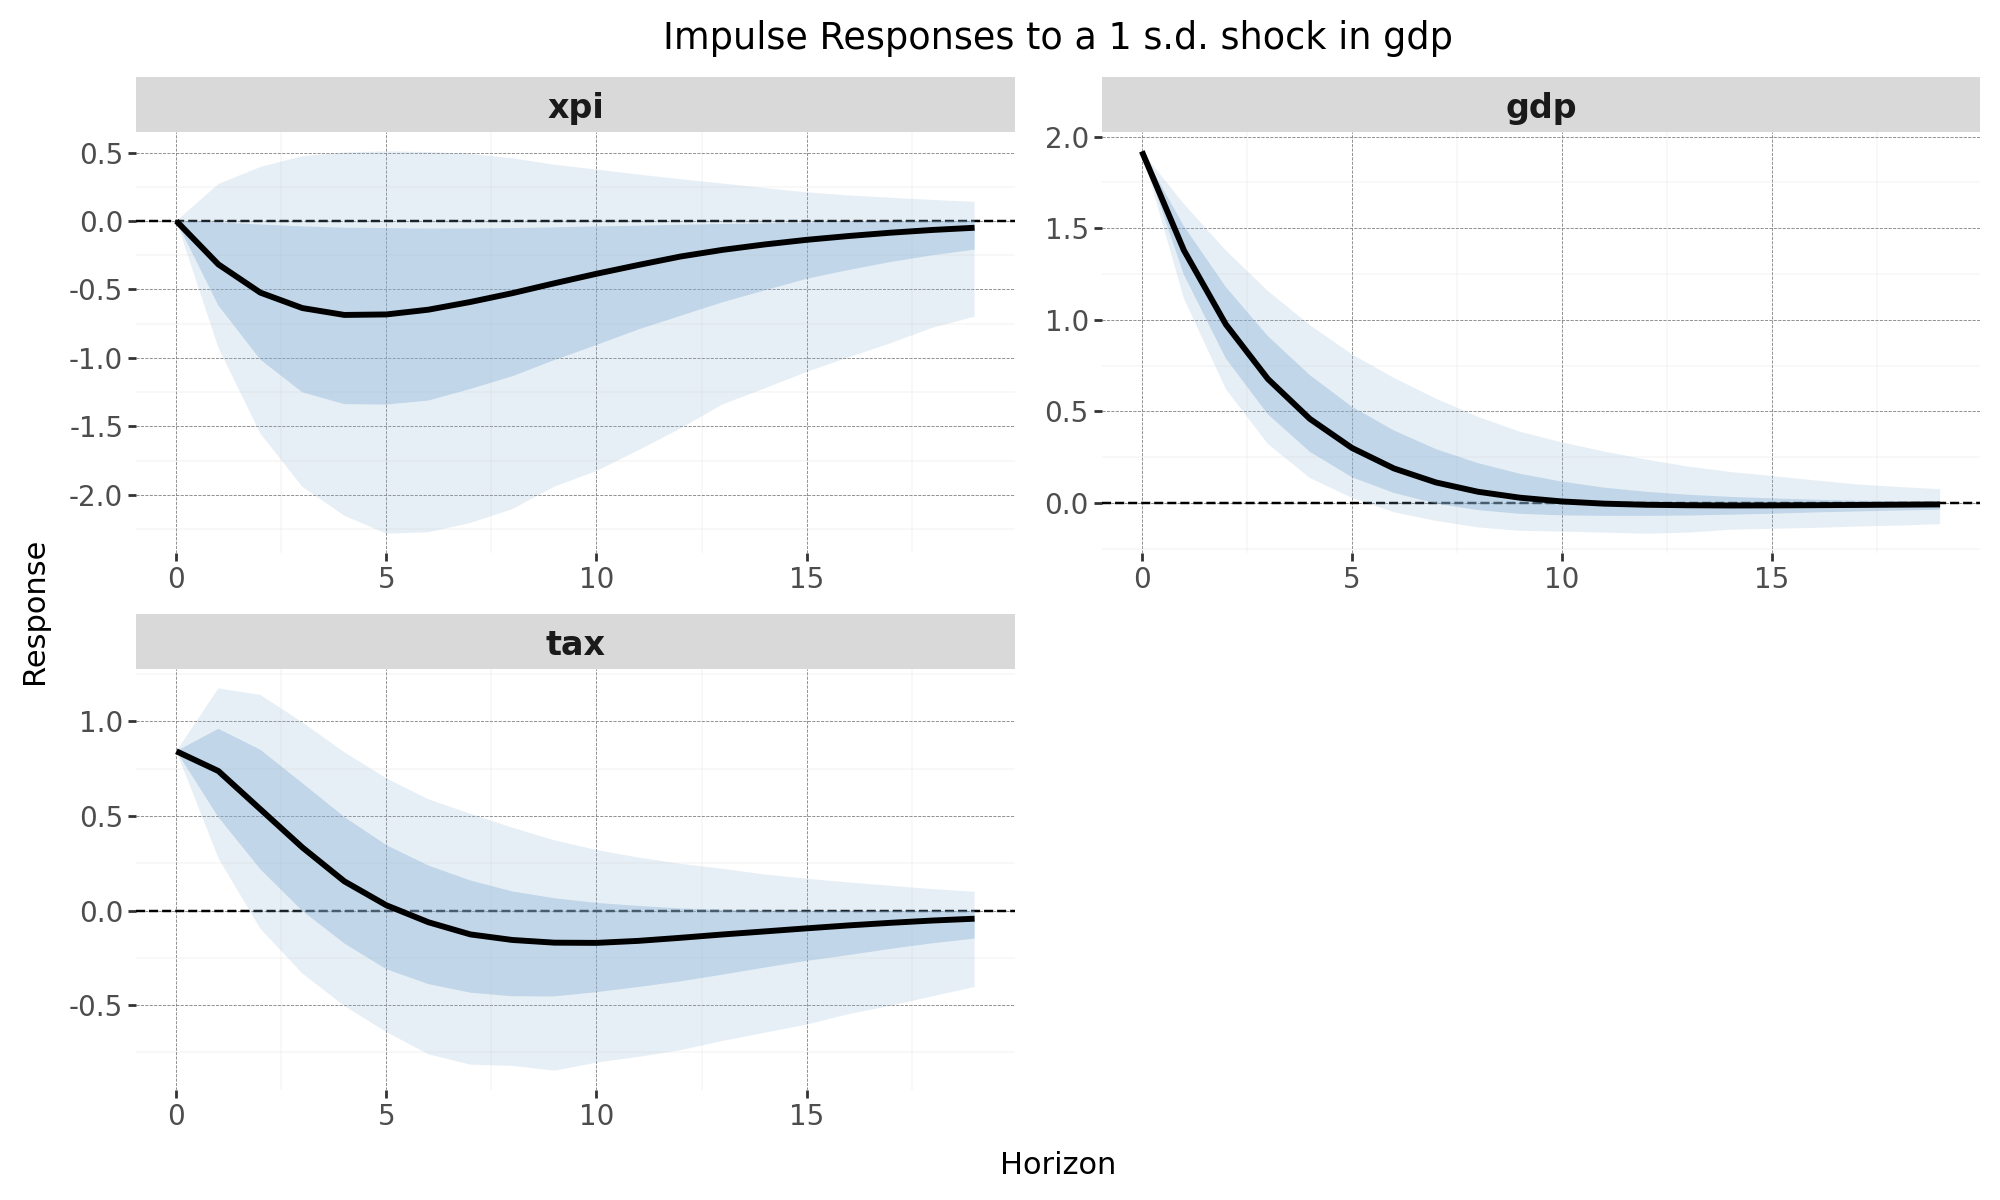

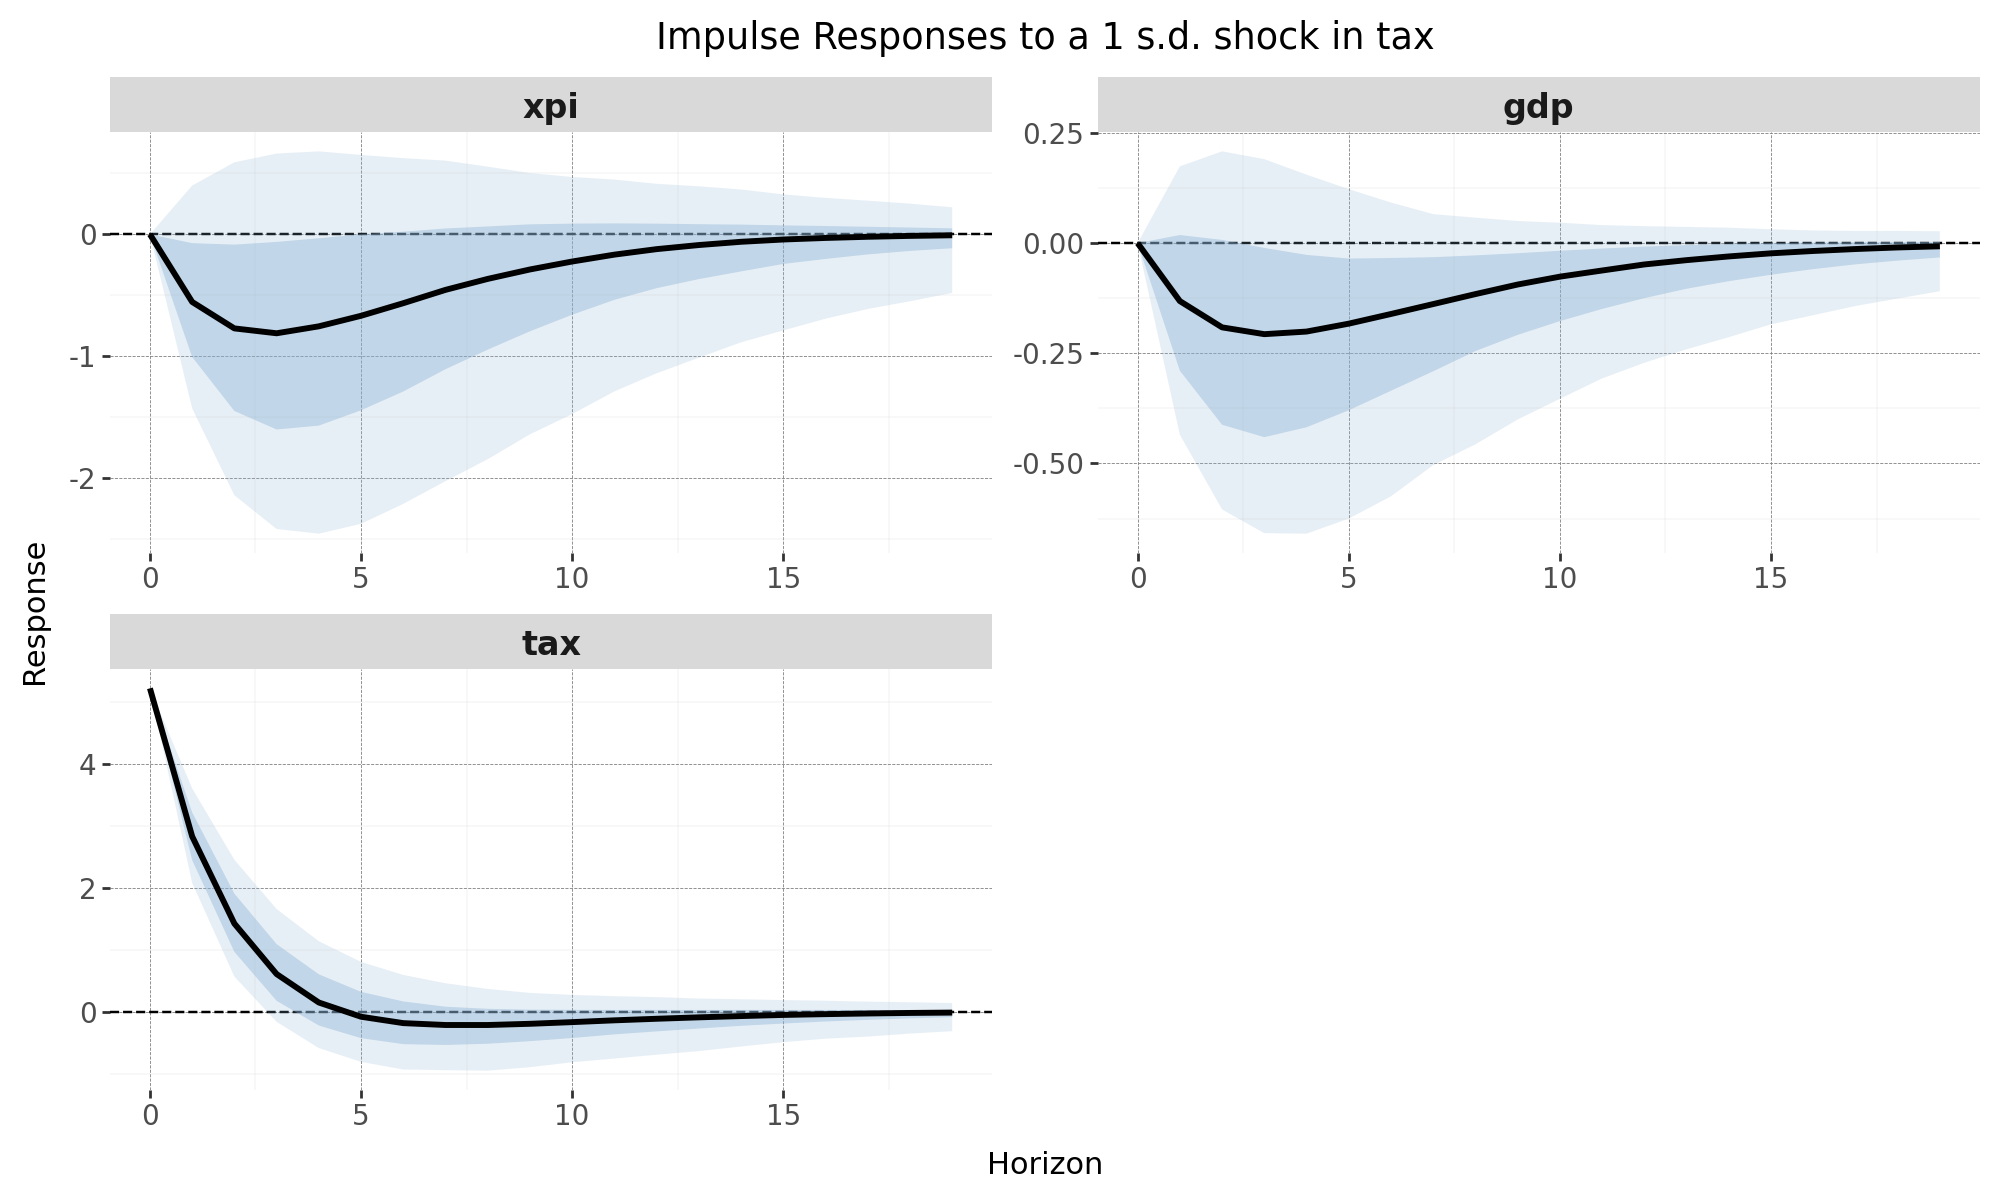

In [14]:
irfs = bvar.compute_irfs(plot_irfs=True, cred_interval=[0.68, 0.95])

## 5. Forecast Error Variance Decomposition (FEVD)

FEVD helps us understand how much of the forecast error in each variable is explained by shocks to itself and to other variables. It is computed using the **Wold representation** of the VAR.

Computing FEVD: 100%|██████████| 2500/2500 [00:00<00:00, 2634.31it/s]


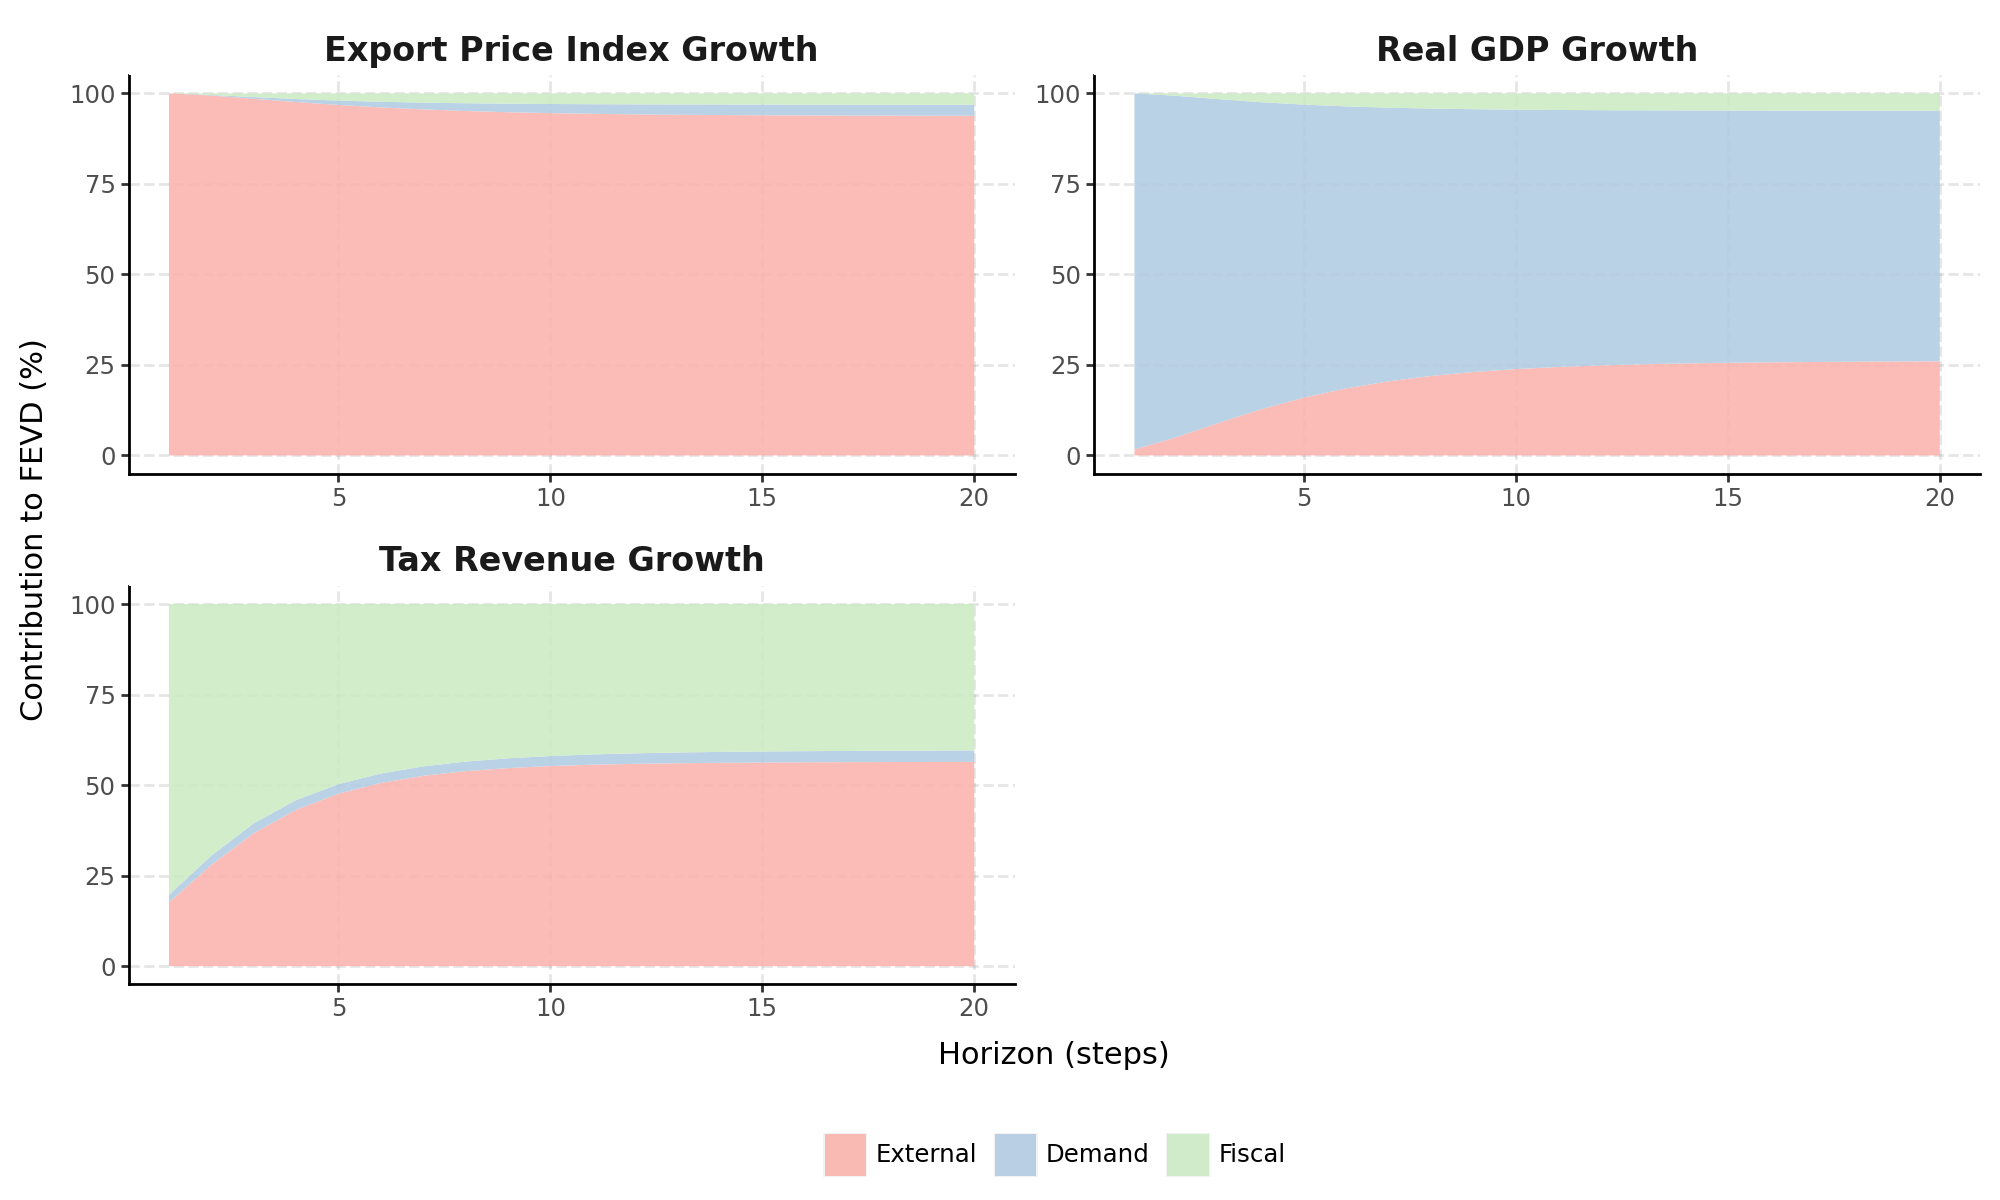

In [15]:
fevd = bvar.compute_fevd(series_titles=series_titles, plot_fevd=True, 
                         shock_titles=["External", "Demand", "Fiscal"])

## 6. Unconditional Forecast

We now generate **unconditional forecasts** from the Bayesian VAR model over a 12-month horizon.

This forecast assumes that no future shocks are imposed. The system evolves based solely on its estimated dynamics and historical data.

The command below draws from the posterior predictive distribution and plots the forecast paths along with **credible intervals** at 90%, 60%, and 30% levels.

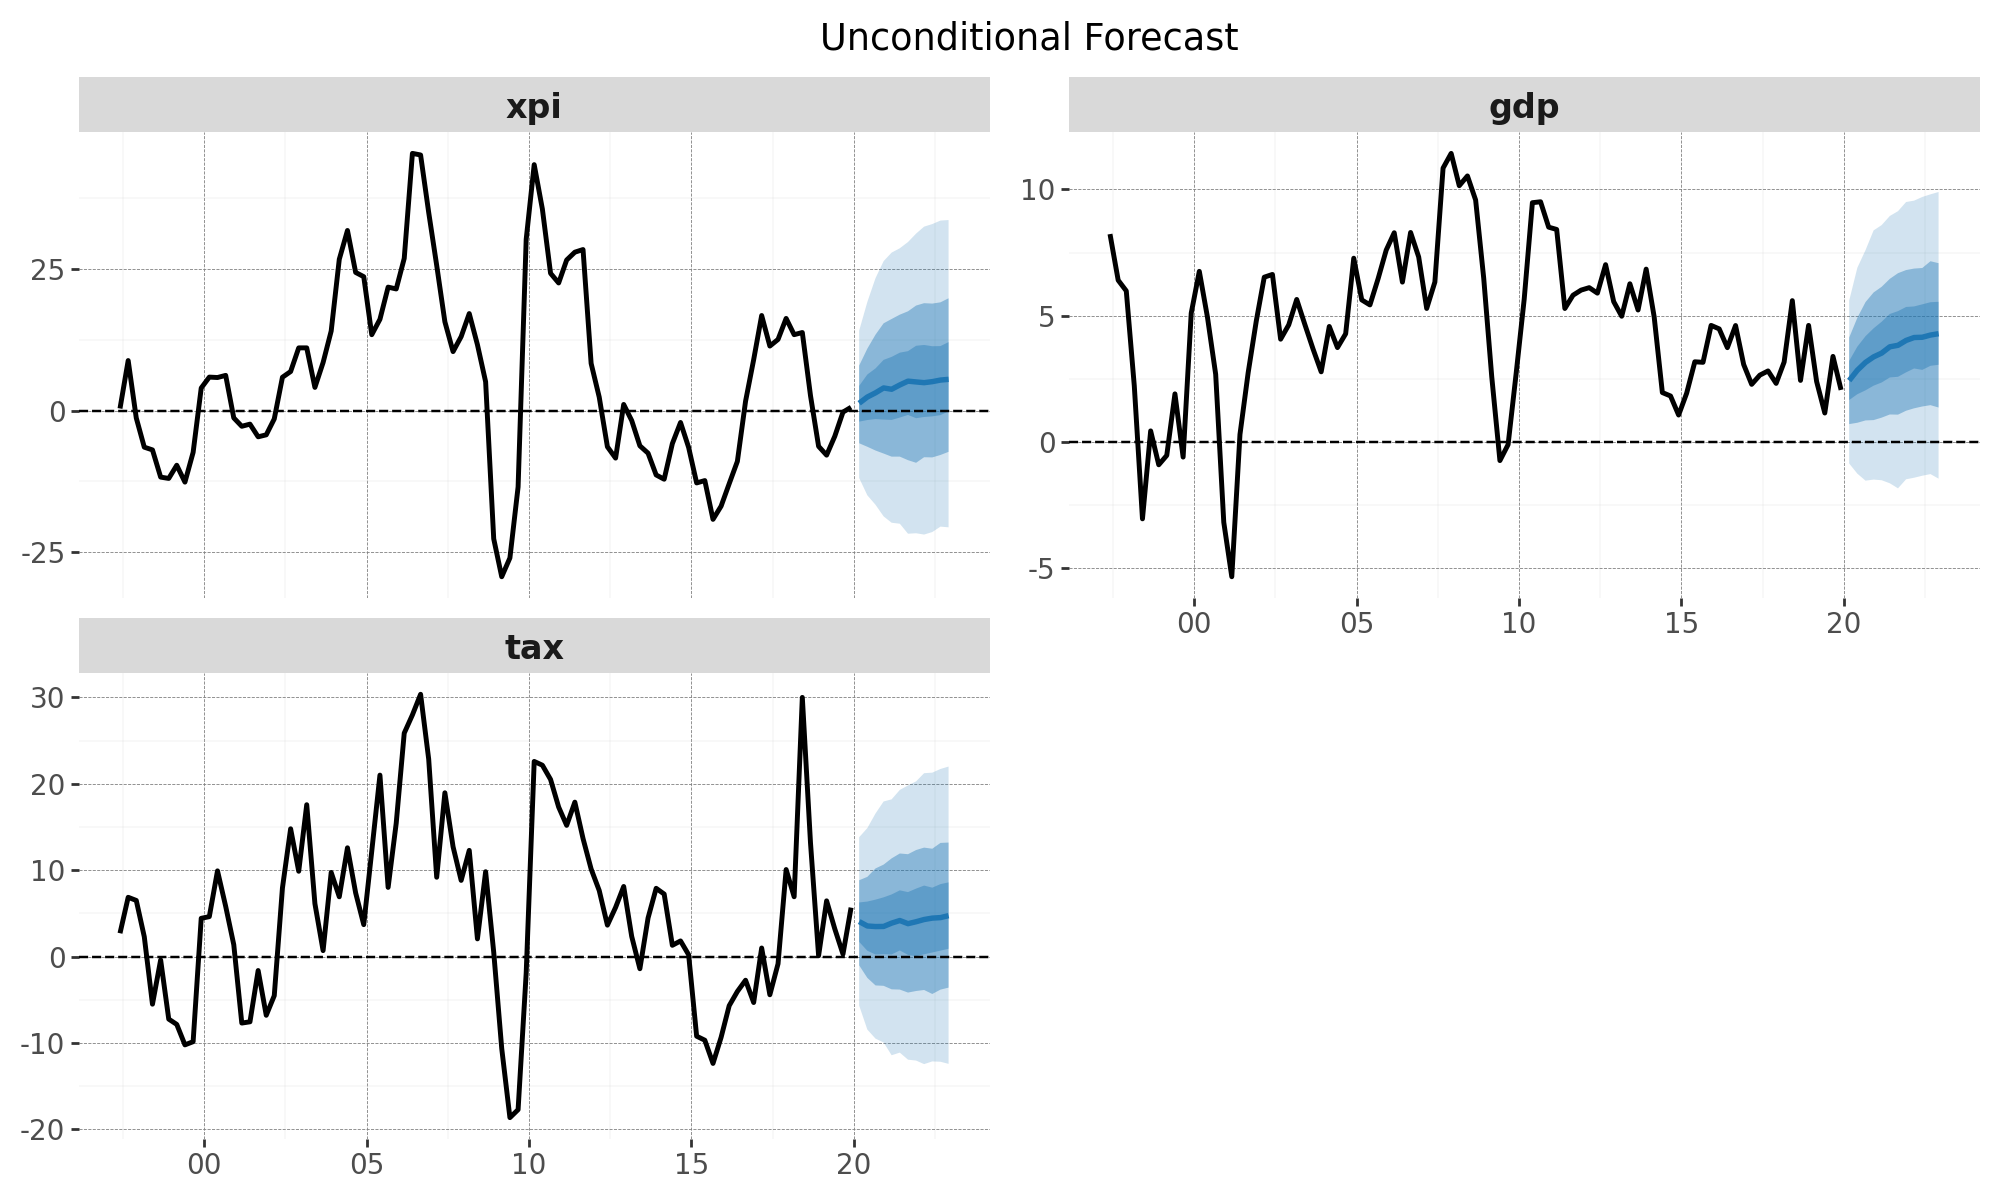

In [16]:
# Unconditional forecasts
fhor = 12
forecasts = bvar.forecast(fhor=fhor, plot_forecast=True, cred_interval=[0.90, 0.60, 0.30], zero_line=True)

## 7. Conditional Forecasts

We now generate **conditional forecasts**, where we impose specific values for one or more variables over the forecast horizon.

In this example, we condition on a hypothetical path for the **export price index growth** (assumed to be the first variable in the system), specifying a sharp temporary decline followed by a gradual recovery.

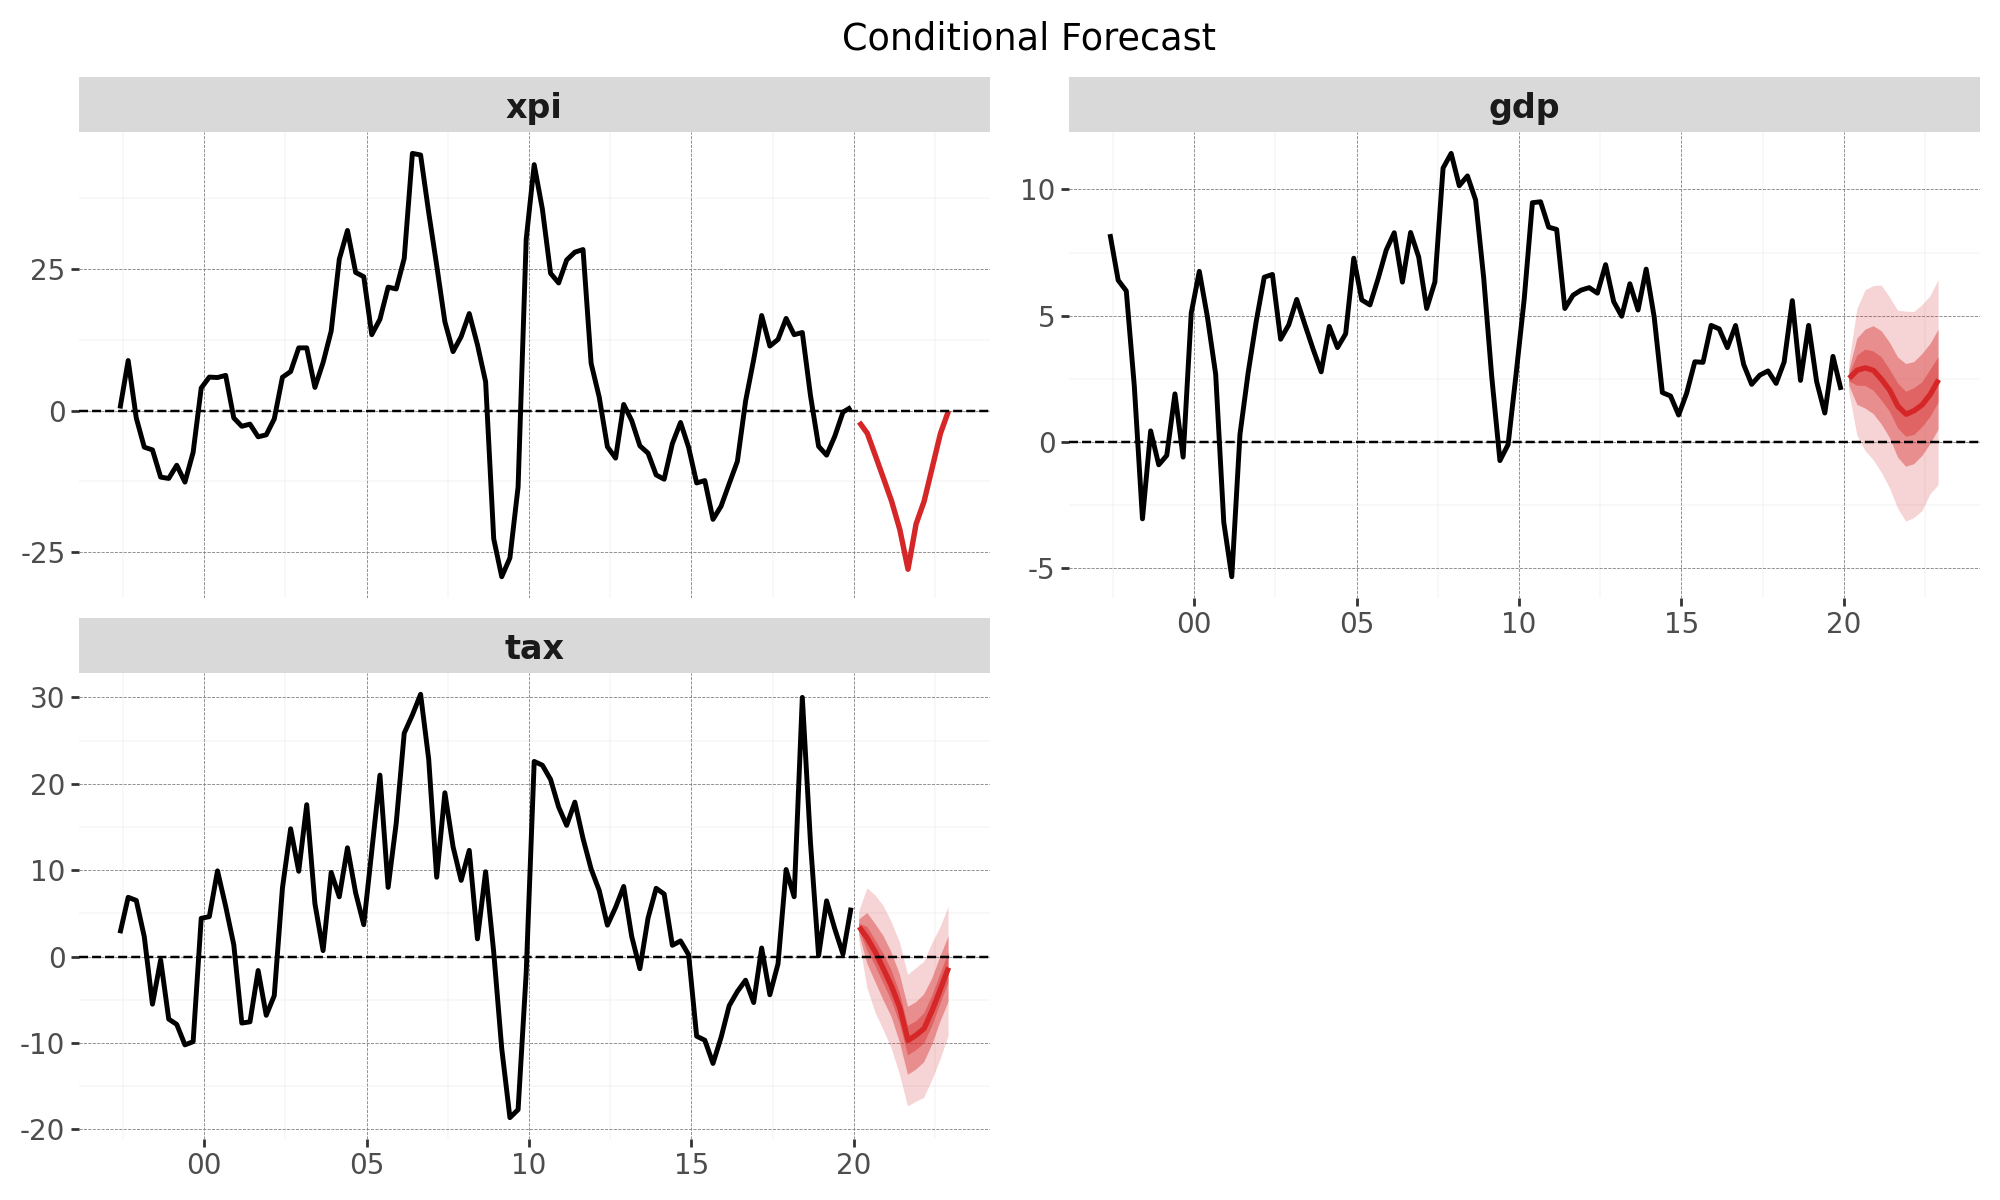

In [17]:
# Conditional forecasts
import numpy as np

conditions = np.full((fhor, 3), np.nan)
conditions[:, 0] = [-2, -4, -8, -12, -16, -21, -28, -20, -16, -10, -4, 0]  # condition on export price index growth
cf, shocks = bvar.conditional_forecast(conditions, fhor=fhor, plot_forecast=True, cred_interval=[0.90, 0.60, 0.30], zero_line=True)

# A More Realistic Model Specification

In this version, we estimate a **Bayesian VAR with 2 lags** using a more flexible and economically grounded structure:

- We apply a **Normal-Wishart prior** (`prior_type=2`) with moderately informative hyperparameters.
- We also introduce **block exogeneity** restrictions reflecting the idea that domestic variables may not influence foreign variables.
- We then estimate the model with 100,000 posterior draws and a burn-in of 90%.

In [18]:
import numpy as np
from MacroPy import BayesianVAR

prior_params = {"mn_mean": 0.5, "lamda1": 2, "lamda2": 1}
block_exog = np.array([
    [0, 1, 1],  # Variable 2, 3 does NOT affect equation 1
    [0, 0, 0],  # No restriction in equation 2
    [0, 0, 0],  # No restriction in equation 3
])
bvar2 = BayesianVAR(df, lags=2, prior_type=2, prior_params=prior_params, b_exo=block_exog, post_draws=100000, burnin=0.9, irf_1std=0)
bvar2.model_summary()


**MacroPy Toolbox for Macroeconometric Analysis in Python**  
Developed by [Renato Vassallo](https://www.linkedin.com/in/renatovassallo), Institute for Economic Analysis (IAE-CSIC)  
Version 0.1.3, May 2025  

---

**Model Specifications**  
- **Model Type**: Bayesian VAR  
- **Endogenous Variables**: xpi, gdp, tax  
- **Exogenous Variables**: Constant   
- **Number of Lags**: 2  
- **Total Number of Coefficients to Estimate**: 21  

---

**MCMC Algorithm**: Gibbs Sampling  
- **Prior Type**: Normal-Wishart  
- **Iterations**: 100000  
- **Burn-in**: 90000 (90%)  

---

**Forecast & IRF Details**  
- **Impulse Response Horizon**: 20  
- **Forecast Horizon**: 12  
- **IRF Computation**: Unit Shock  

---

**VAR Model Equations**

$$
\begin{align*}
xpi_{t} &= b_{1,1}^{1} xpi_{t-1} + b_{1,2}^{1} gdp_{t-1} + b_{1,3}^{1} tax_{t-1} + b_{1,1}^{2} xpi_{t-2} + b_{1,2}^{2} gdp_{t-2} + b_{1,3}^{2} tax_{t-2} + c_{1} + e_{t}^{xpi} \\
gdp_{t} &= b_{2,1}^{1} xpi_{t-1} + b_{2,2}^{1} gdp_{t-1} + b_{2,3}^{1} tax_{t-1} + b_{2,1}^{2} xpi_{t-2} + b_{2,2}^{2} gdp_{t-2} + b_{2,3}^{2} tax_{t-2} + c_{2} + e_{t}^{gdp} \\
tax_{t} &= b_{3,1}^{1} xpi_{t-1} + b_{3,2}^{1} gdp_{t-1} + b_{3,3}^{1} tax_{t-1} + b_{3,1}^{2} xpi_{t-2} + b_{3,2}^{2} gdp_{t-2} + b_{3,3}^{2} tax_{t-2} + c_{3} + e_{t}^{tax} \\
\end{align*}
$$


Computing IRFs: 100%|██████████| 10000/10000 [00:02<00:00, 4272.03it/s]


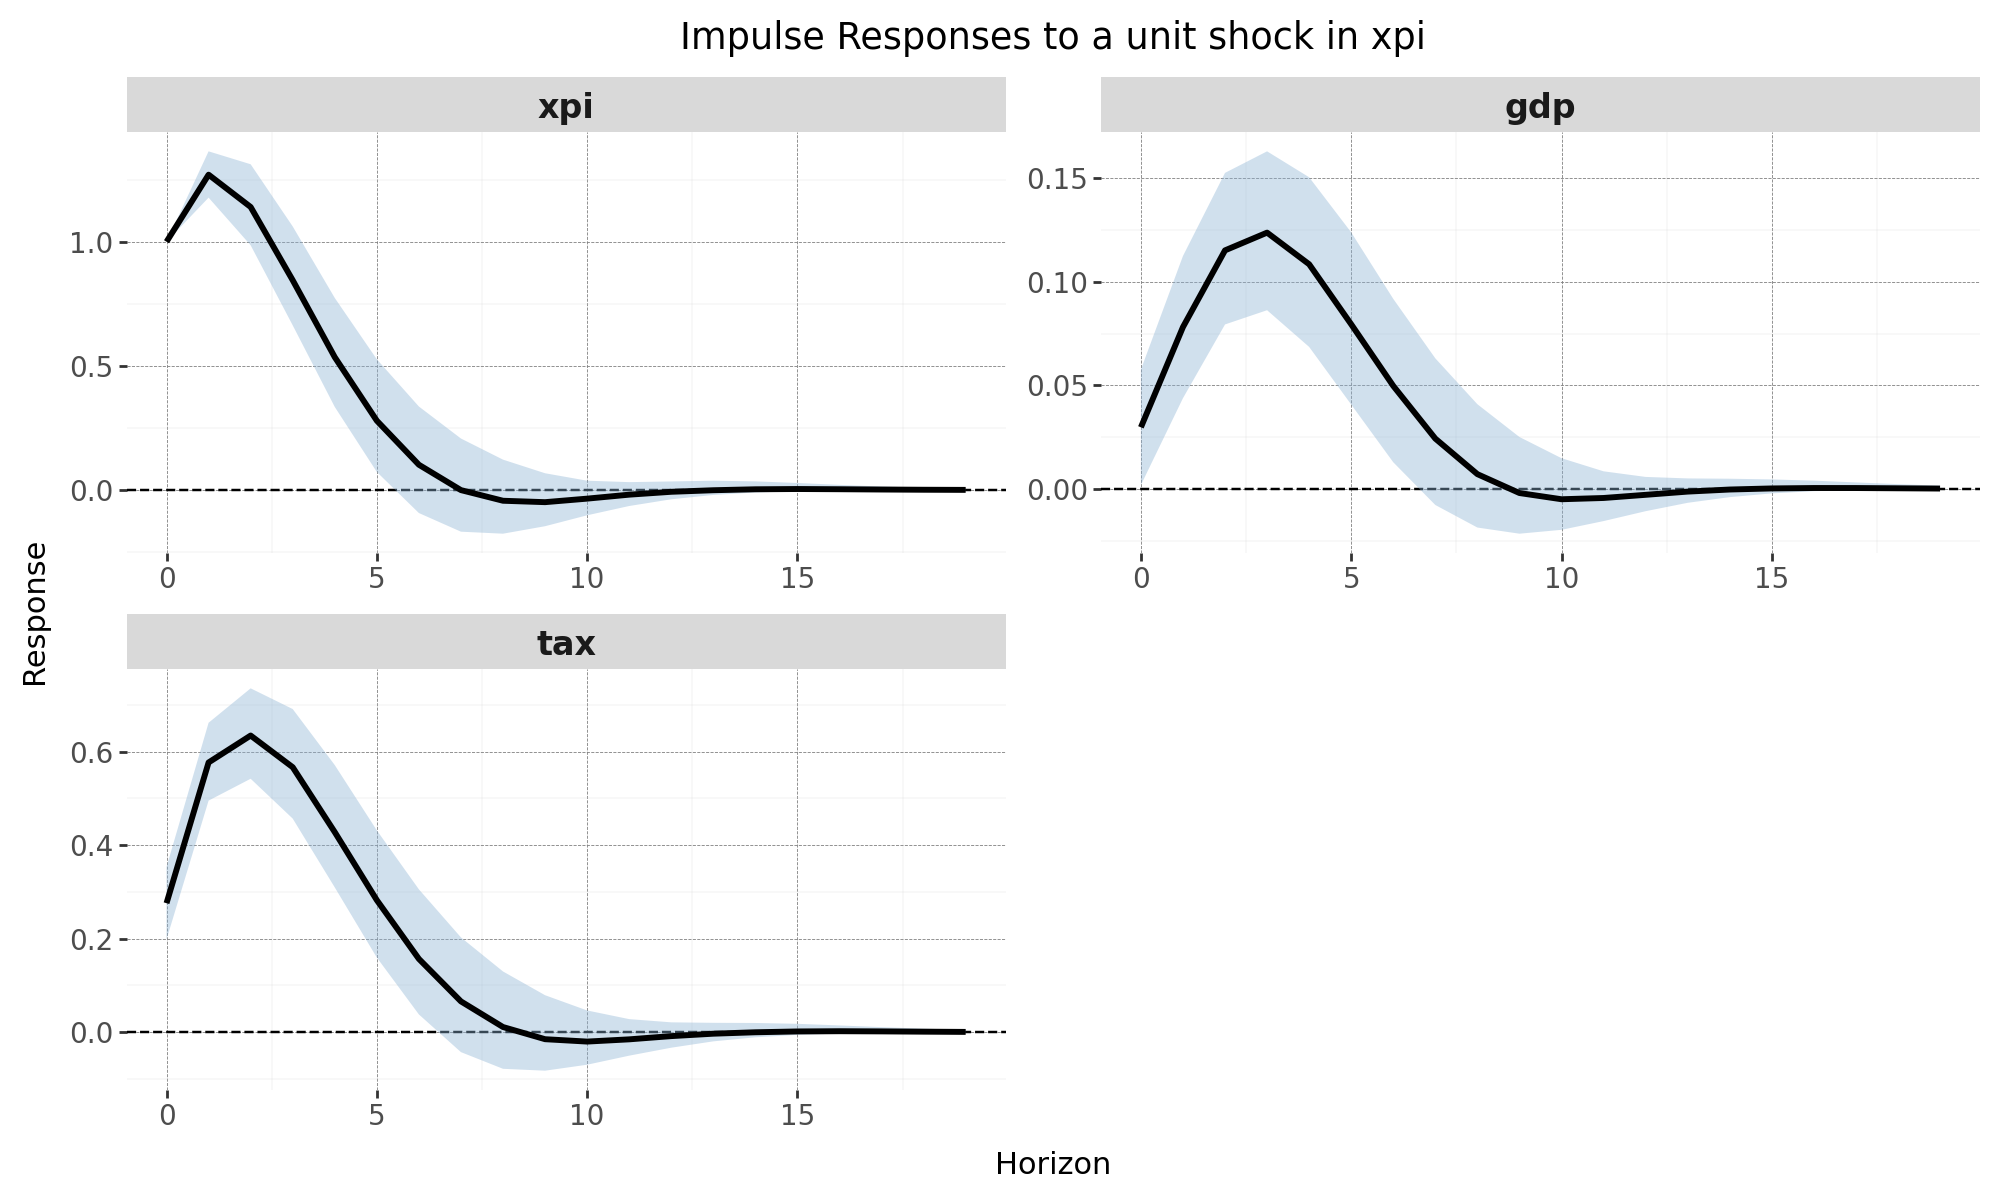

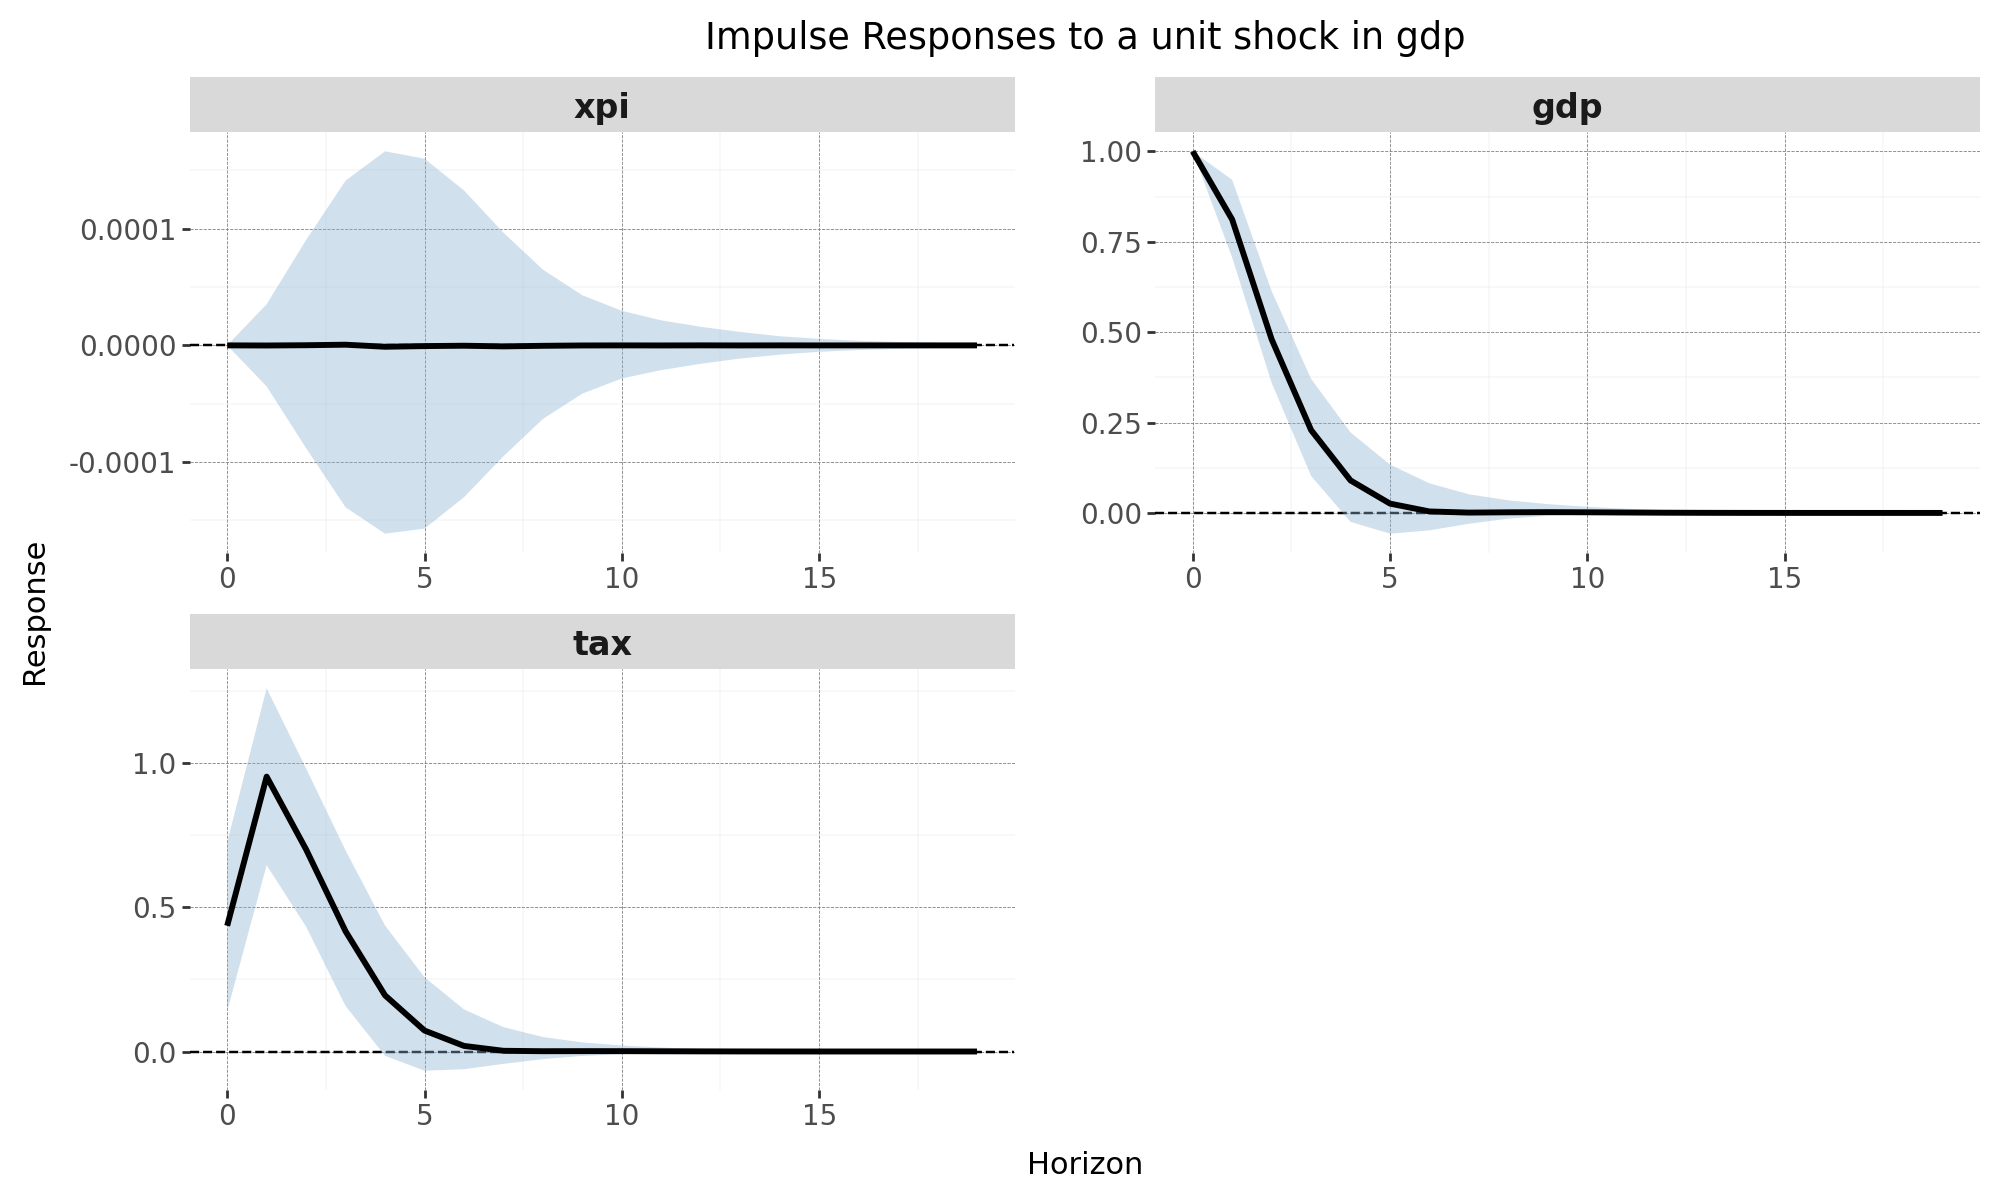

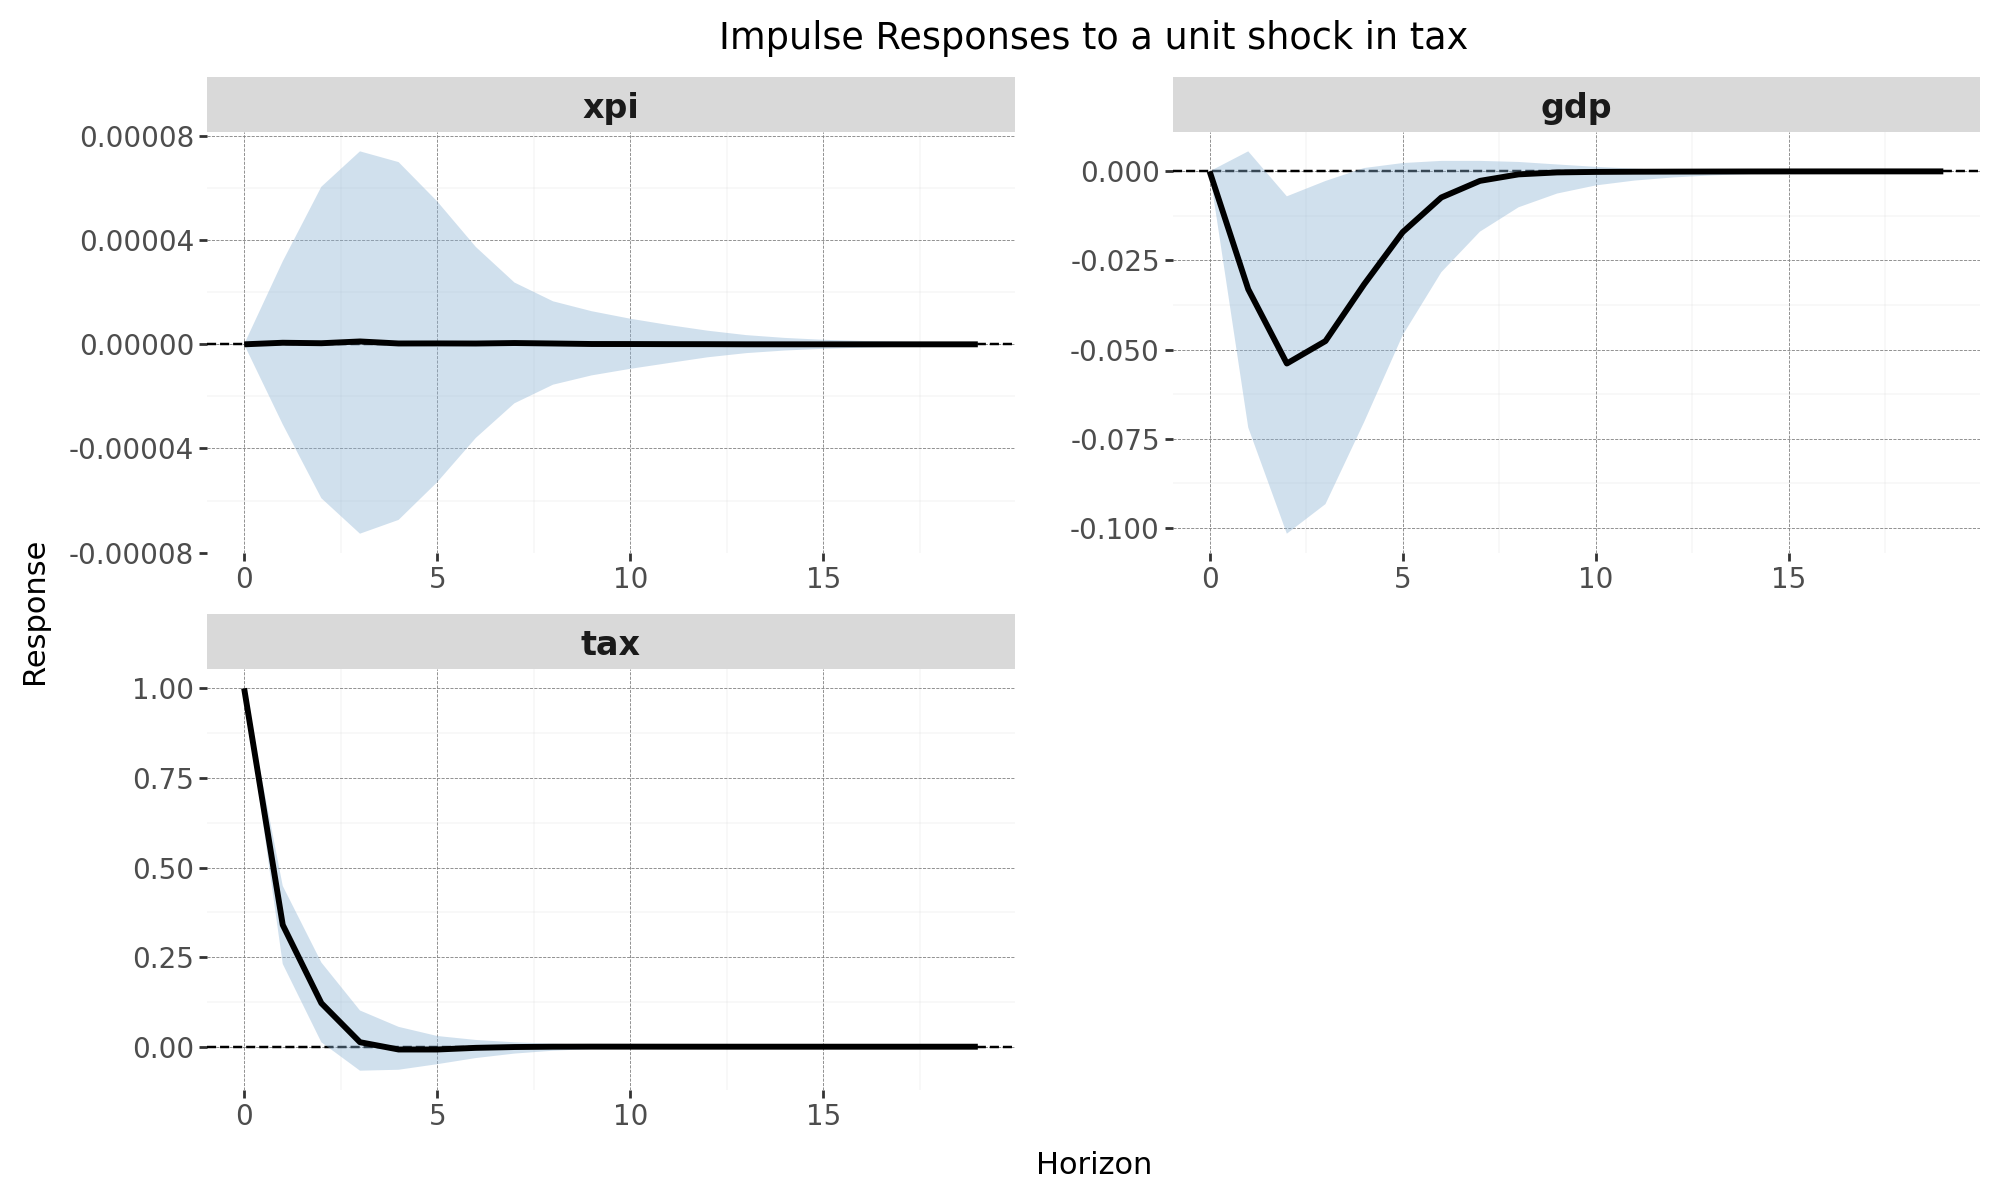

In [19]:
bvar2.sample_posterior(plot_coefficients=False)
irfs2 = bvar2.compute_irfs(plot_irfs=True)

Computing FEVD:   0%|          | 0/10000 [00:00<?, ?it/s]

Computing FEVD: 100%|██████████| 10000/10000 [00:03<00:00, 2524.65it/s]


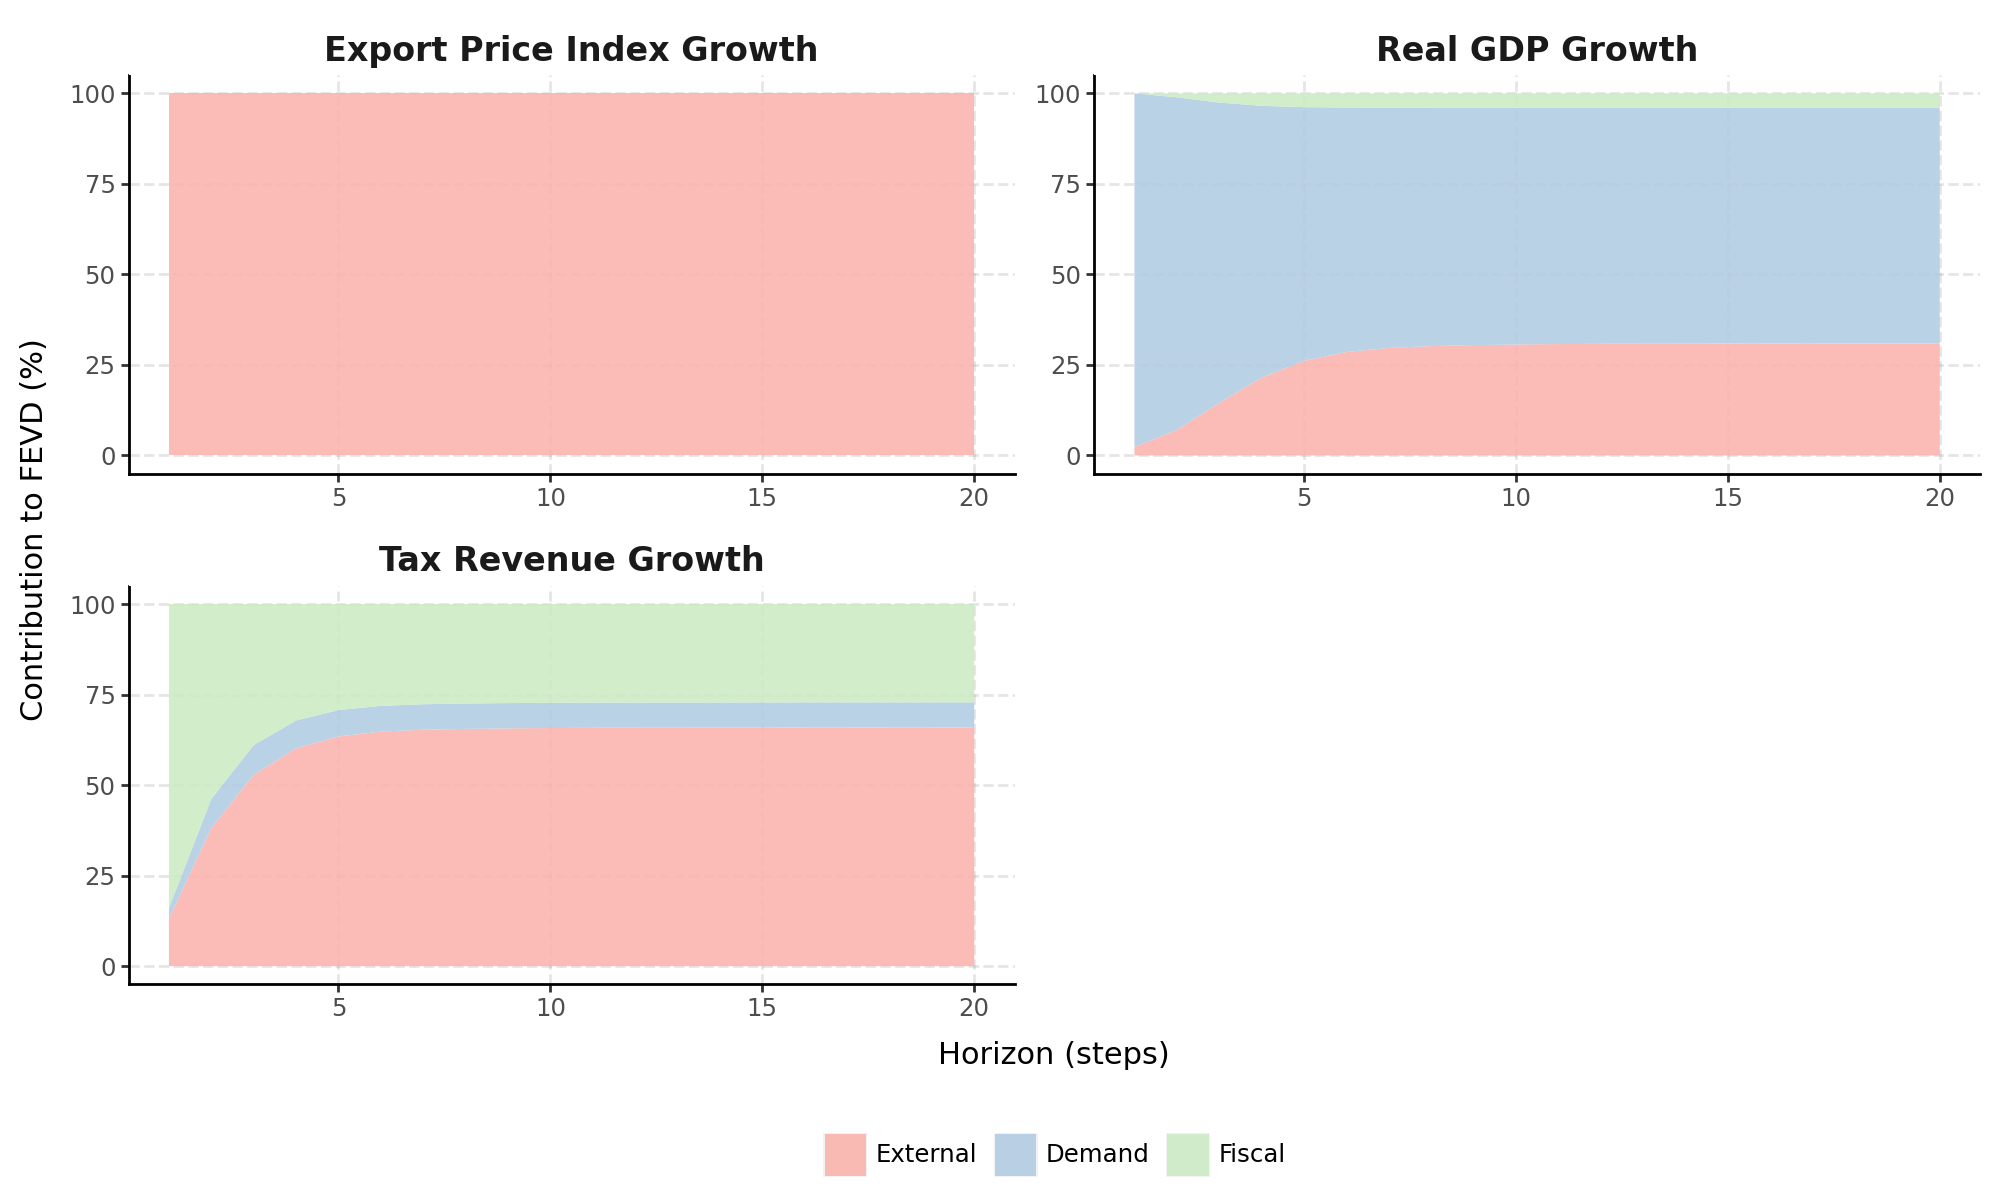

In [20]:
fevd2 = bvar2.compute_fevd(series_titles=series_titles, plot_fevd=True, 
                         shock_titles=["External", "Demand", "Fiscal"])